In [1]:
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.impute import SimpleImputer
pio.renderers.default = 'notebook'
sns.set_palette('bright')

pd.set_option('display.max_rows', 30)

sns.set_context(rc={"font.size":8,"axes.titlesize":10,"axes.labelsize":8}) 
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

# Новые признаки

У нас остались не исследованные признаки – заголовок, модификация, поколение и список расстояний от метро и станций метро. Из данных переменных можно взять информацию об удаленности точни продажи до метро в целом, а также среднее время от предлагаемых станций метро. 

Из заголовка можно найти информацию о марке машины, а сама модификация скорее всего окажется бесполезным признаком с большим числом различных значений, который довольно тяжело интерпретировать и использовать в целом. 

Также вынесем флаг предыдущей продажи в отдельную переменную.


In [2]:
df = pd.read_csv('datasets/final_dataset.csv', index_col='Unnamed: 0')

df.head()

,title,year,age,run,owners_pts,modification,volume,engine_type,transmission,gear,...,exchange,mark,other_history,tech_history,sold,subway,pts_type,price,horse_power,price_log
0,Kia K900 3.3 AT,2019,II,91037,2,3.3 4WD AT,3.3,0,Автомат,Полный,...,Возможен,соответствует,2,4,1,Аннино:6–10 мин.;Лесопарковая:11–15 мин.;Улица...,Другое,2999000,249,14.913790
1,Mercedes-Benz V-класс 2.1 AT,2017,W447,95250,2,V 250 d 2.1 4MATIC AT L3,2.1,1,Автомат,Полный,...,Не интересует,соответствует,2,19,2,Проспект Вернадского:до 5 мин.;Новаторская:16–...,Оригинал,5650000,190,15.547166
2,Opel Astra GTC 1.4 AT,2013,J рестайлинг,113000,2,1.4 Turbo AT,1.4,0,Автомат,Передний,...,Возможен,ниже,2,5,3,Южная:11–15 мин.;Чертановская:21–30 мин.;Пражс...,Другое,699000,140,13.457407
3,Volkswagen Tiguan 2.0 AT,2015,I рестайлинг,165000,2,2.0 TDI 4Motion AT,2.0,1,Автомат,Полный,...,Возможен,ниже,2,5,1,Волоколамская:16–20 мин.;Мякинино:от 31 мин.;Т...,Другое,1195000,140,13.993658
4,Ford Kuga 1.5 AT,2018,II рестайлинг,103000,1,1.5 EcoBoost 4WD AT,1.5,0,Автомат,Полный,...,другое,соответствует,1,10,1,Ховрино:до 5 мин.;Беломорская:21–30 мин.;Речно...,Оригинал,1780000,150,14.392124


Для начала добавим признак наличия только одного владельца, так как скорее всего если у машины было несмколько владельцев, то ее цеена должна падать

In [3]:
df['one_owner'] = df['owners_pts'].apply(lambda x: 1 if x == '1' else 0)

теперь разберемся со станциями метро:

In [4]:
df['subway'].head()

0    Аннино:6–10 мин.;Лесопарковая:11–15 мин.;Улица...
1    Проспект Вернадского:до 5 мин.;Новаторская:16–...
2    Южная:11–15 мин.;Чертановская:21–30 мин.;Пражс...
3    Волоколамская:16–20 мин.;Мякинино:от 31 мин.;Т...
4    Ховрино:до 5 мин.;Беломорская:21–30 мин.;Речно...
Name: subway, dtype: object

In [5]:
df['subway'][0], df['subway'][1]

('Аннино:6–10 мин.;Лесопарковая:11–15 мин.;Улица Старокачаловская:21–30 мин.',
 'Проспект Вернадского:до 5 мин.;Новаторская:16–20 мин.;Мичуринский проспект:21–30 мин.')

Формат хранения информации в данной колонке следующий: 
Название метро: время; Название метро 2: время2 и тд
Нам бы хотелось найти среднее время до метро относительно места, где можно забрать машину, так как вдальнейшем можно будет выдвинуть гипотезу о том, что если до метро идти слишком долго, то цена может быть снижена (так как при продаже возле метро издержки на доставку машины у владельца выше => машина дороже)

In [6]:
def extract_mins(row):
#     print(type(row))
    if not row or type(row) != str:
        return None
    minute_ranges = re.findall(r':(\d+–\d+ мин.|до \d+ мин.|от \d+ мин.)', row)
    total_minutes = 0
    count = 0

    for minute_range in minute_ranges:
        # Extract minutes and calculate the average if it is a range
        
        if '–' in minute_range:
            min_min, max_min = map(int, minute_range.split()[0].split('–'))
            average = (min_min + max_min) / 2
        else:
            average = int(minute_range.split()[1])

        total_minutes += average
        count += 1
    return round(total_minutes / count, 2) if count > 0 else None

df['subway_avg_mins'] = df['subway'].apply(lambda x: extract_mins(x))

In [7]:
df['subway_avg_mins'].head()

0    15.50
1    16.17
2    21.33
3    26.67
4    20.50
Name: subway_avg_mins, dtype: float64

Посмотрим на наличие пропусков. Если они есть – заполним средним

In [8]:
df['subway_avg_mins'].isna().sum()

23

In [9]:
mean_avg = df['subway_avg_mins'].mean()
df['subway_avg_mins'].fillna(mean_avg, inplace=True)

Последний признак, который стоит использовать – марка машины, которую мы можем взять из названия. Будем исходить из предположения, что это первое слово (тк остальные слова уже относятся к конкретной серии / спецификации)

In [10]:
df['car_brand'] = df['title'].apply(lambda x: x.split()[0])
df['car_brand'].head()

0              Kia
1    Mercedes-Benz
2             Opel
3       Volkswagen
4             Ford
Name: car_brand, dtype: object

Посмотрим на корреляцию новосозданных признаков с целевой переменной (из прошлой части мы поняли что лучше смотреть на логарифм цены, так как он распределен нормально).

In [11]:
df['one_owner'].corr(df['price_log'])

0.31875216633546344

Видим небольшую положительную корреляцию, что может означать небольшое положительное влияние 1 прошлого владельца на цену (то есть, чем меньше владельцев то цена выше)

In [12]:
df['subway_avg_mins'].corr(df['price_log'])

-0.09969025647971552

как и ожидалось, присутствует небольшая отрицательная корреляция – чем дальше расстояние от метро, тем цена ниже

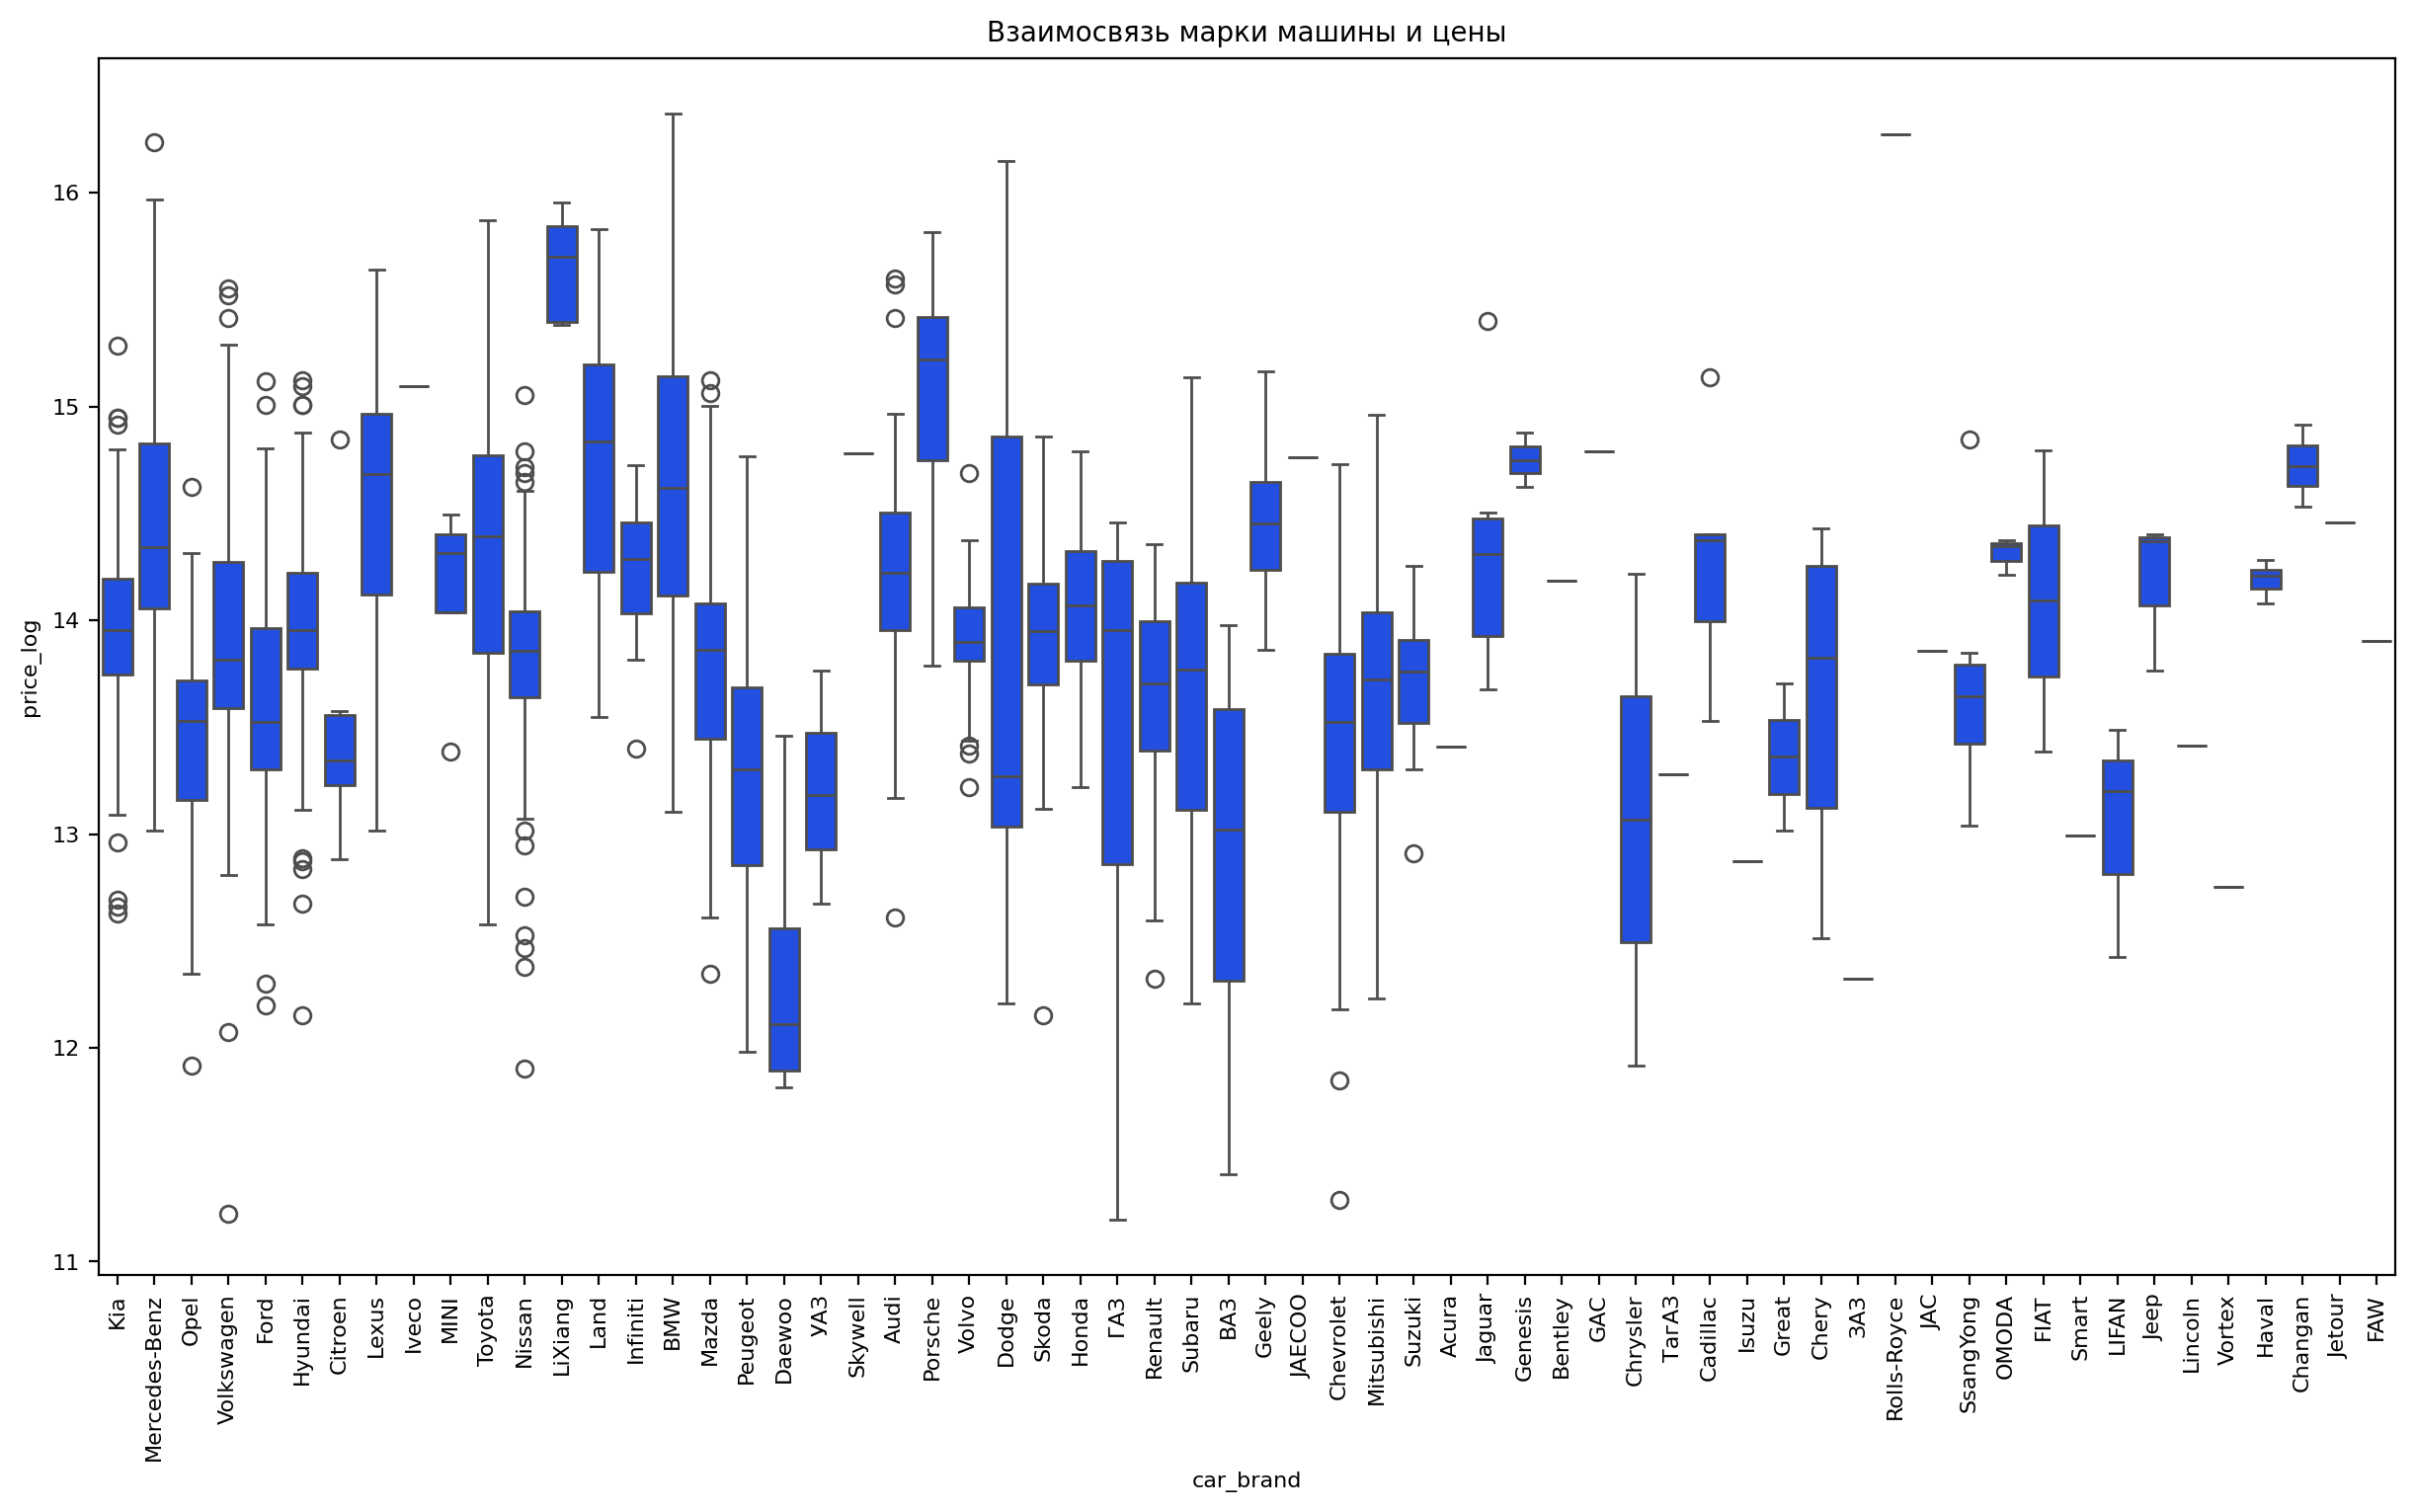

In [13]:
plt.figure(figsize = (15, 8))
sns.boxplot(x='car_brand', y='price_log', data=df)
plt.title('Взаимосвязь марки машины и цены')
plt.tick_params(axis='x', labelrotation=90)
# df['car_brand'].corr(df['price_log'])

можем заметить, что цена и правда варьируется от марки машины и например машины модели LiXiang являются самыми дорогими (что, тв целом, неудивительно, учитывая что машина является электромобилем), а такие марки как Daewoo или УАЗ обычно ниже в цене. Также стоит учитывать большой разброс значений для некоторых особо популярных марок машин (таких как Skoda, ВАЗ, Opel, Mercedes-Benz и тд)

# Гипотезы

Исходя из предыдущего анализа, проверим следующие гипотезы:
1. Влияет ли наличие только 1 владельца по ПТС на цену?
2. Влияет ли цвет машины на цену, а конкретно правда ли, что черные, серые, серебрянные и белые машины дешевле разноцветных машин?
3. Правда ли, что возможность обмена, число предыдущих продаж и тех. история практически никак не влияют на цену?

## Влияет ли наличие только 1 владельца по ПТС на цену?

Пусть у нас будет вектор А с ценами машинами, у которых был ровно 1 владелец, и вектор B с остальными. 
Сформируем гипотезы в формате: 
$$H_0: \mu_a = \mu_b$$

$$H_1: \mu_a > \mu_b$$

То есть будем проверять одностореннюю гипотезу о том, что машины с 1 владельцем дороже. Проверять гипотезу будем на уровне значимости 5%.

Для начала сравним распределения, так как в случае с наличием большого числа выбросов, Z-тест будет нерепрезентативным.


In [14]:
a, b = df[df['one_owner'] == 1]['price_log'], df[df['one_owner'] != 1]['price_log']

a.mean(), b.mean()

(14.19964279788463, 13.750390256325593)

Сразу можем заметить, что логарифм цен немного отличается (Небольшие отличия в логорифме цены могут говорить о значительных отличиях самой цены. Ради интереса посмотрим именно на отличия средних в ценах.

In [15]:
df[df['one_owner'] == 1]['price'].mean(), df[df['one_owner'] != 1]['price'].mean()


(1822719.4923928077, 1174800.481025641)

Видим, что цены отличаются значительно, но как мы помним из части с визуализацией, мы и берем цену, так как ее распределение близко к нормальному. Убедимся в этом, построив распределения a и b 

<Figure size 1500x600 with 0 Axes>

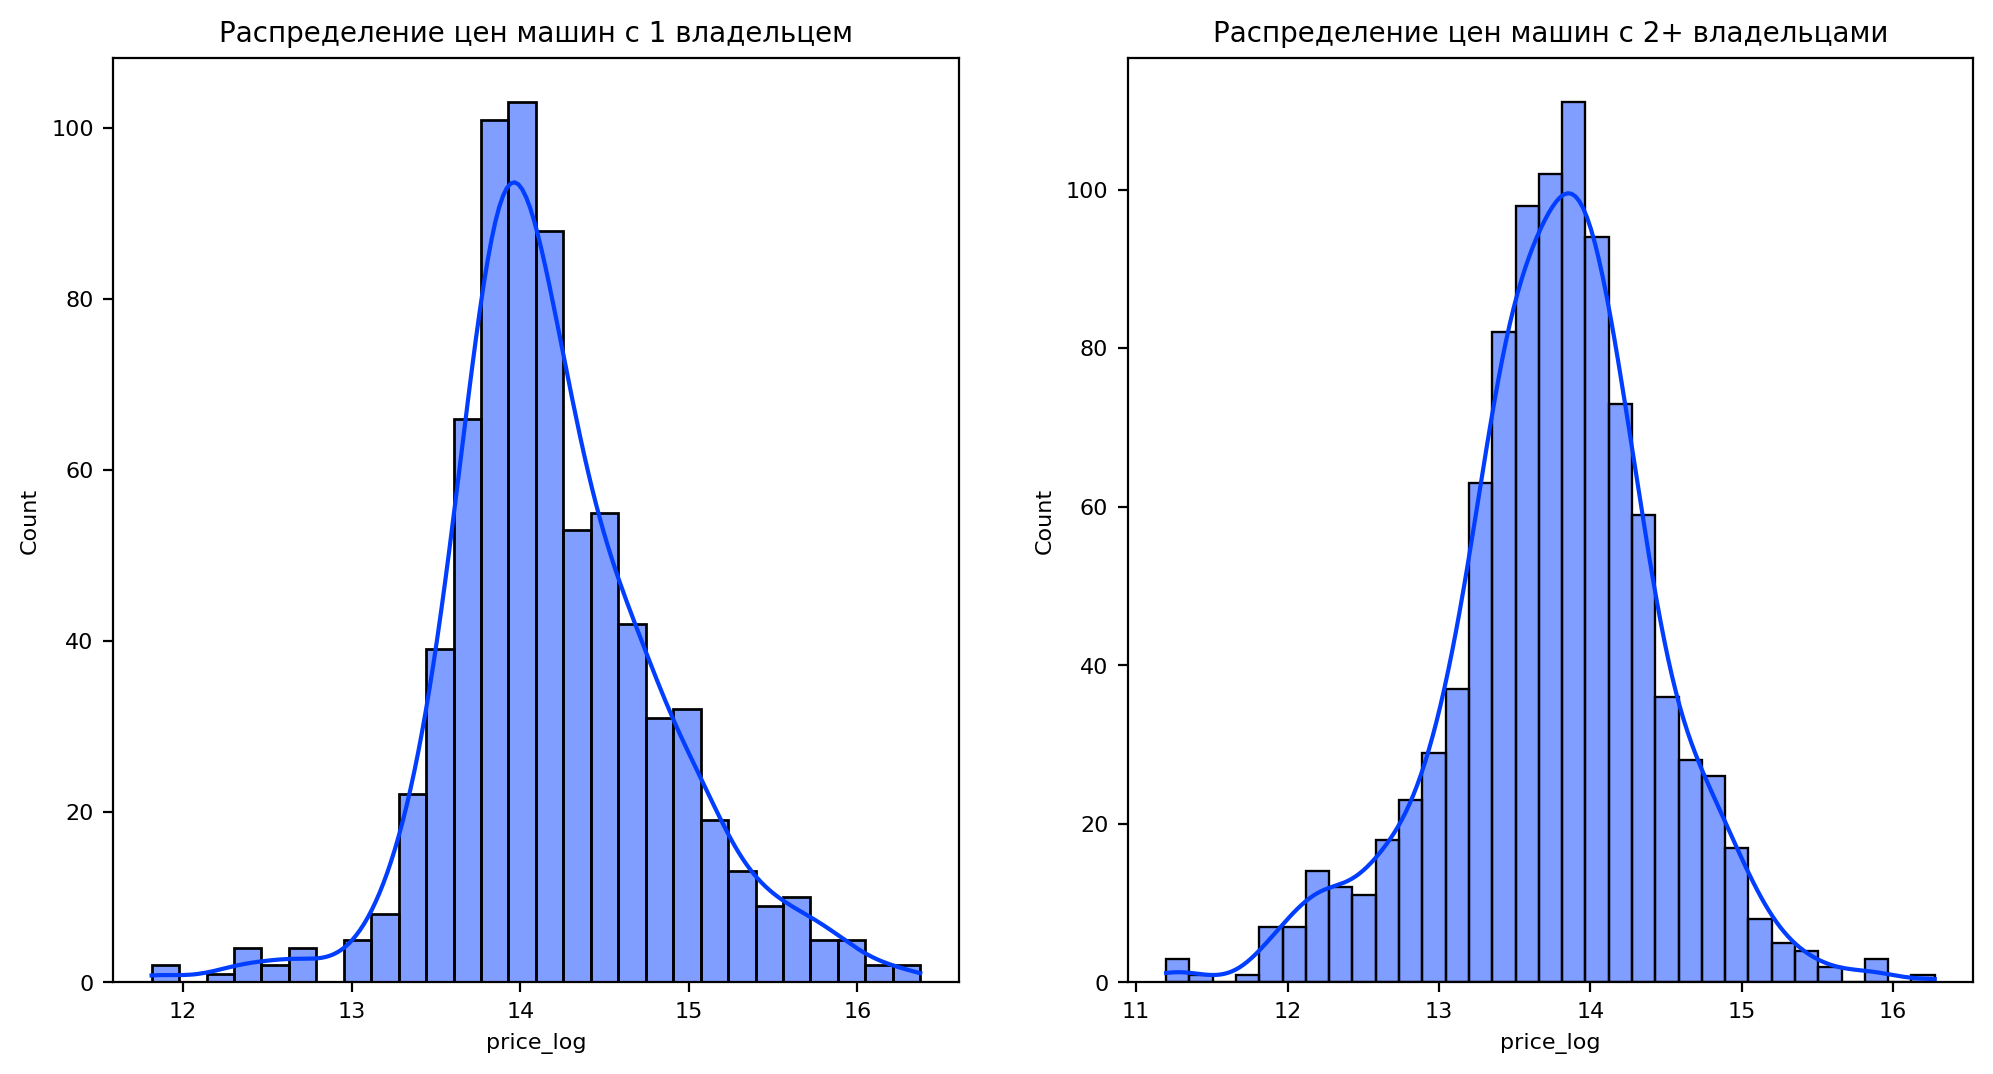

In [16]:

plt.figure(figsize=(15, 6))
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

sns.histplot(a, kde=True, ax=axes[0]) 
axes[0].set_title('Распределение цен машин с 1 владельцем')

sns.histplot(b, kde=True, ax=axes[1]) 
axes[1].set_title('Распределение цен машин с 2+ владельцами')

plt.show()

видим, что распределение с 1 владельцем слегка смещено влево, распределение с 2+ владельцами похоже на нормальное. Так как есть выбросы, то можем применить тест Манна-Уитни

In [17]:
# код ниже взять из семинара
from scipy import stats
import statsmodels as sts 

def asy_mean_test(mean_hat, std_hat, mu_0=0, 
                   alpha=0.05, alternative='two-sided', margin=3):
    """
        Асимптотический тест для равенства средних
    """
    
    z_obs = (mean_hat - mu_0)/std_hat
    
    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm().cdf(np.abs(z_obs)))
        z_crit = stats.norm().ppf(1 - alpha/2)
        
        statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (z_crit, 0.05, z_crit, margin, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r'), 
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    if alternative == 'less':
        p_value = stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)
        
        statistics = ['-z_crit', '-z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (-z_obs, -0.6, -margin, -z_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)
        
        statistics = ['z_crit', 'z_obs']
        params = dict(zip(statistics, [(z_crit, 0.05, z_crit, margin, 'b'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    
    plt.figure(figsize = (8, 4))
    x = np.linspace(-margin, margin)
    pdf = stats.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]
    
    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]
        
        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin, 
                 h*y_max, round(statistic, 2), color=color, fontsize=16)
        
        xq = np.linspace(left_bound, right_bound)
        yq = stats.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)
    
    return p_value

In [18]:

_, pval = stats.mannwhitneyu(a, b, alternative='greater')
pval

8.446986369054091e-40

In [20]:
alpha=0.05
pval < alpha

True

p_val  $ \ge \alpha \Rightarrow$ Наша гипотеза о том, что ноутбуки с 1 владельцем стоят дороже отвергается (тк мы не можем отвергнуть нулевую гипотезу)


## Влияет ли цвет машины на цену?

Пусть у нас будет вектор x с ценами машинами, у которых цвет машин серебряный, черный, белый или серый (будем называть эти цвета "популярными"), и вектор y с остальными. 
Сформируем гипотезы в формате: 
$$H_0: \mu_x = \mu_y$$

$$H_1: \mu_x < \mu_y$$

То есть будем проверять двустороннюю гипотезу о том, что машины популярных цветов дешевле. Проверять гипотезу будем на уровне значимости 5%.


In [21]:
colors = ['Серебряный', 'Серый', 'Белый', 'Черный']
x, y = df[df['color'].isin(colors)]['price_log'], df[~df['one_owner'].isin(colors)]['price_log']

x.mean(), y.mean()

(13.919276070690897, 13.941679766070695)

видим небольшие различия

In [22]:
diff = x.mean() - y.mean() 
nx, ny = x.size, y.size
diff_std = np.sqrt(x.var(ddof=1)/nx + y.var(ddof=1)/nx)
                                    
z_obs = diff/diff_std    
z_crit = stats.norm.ppf(1 - alpha/2) 

print(f'{z_obs:.3} попадает в ({-z_crit:.3} , {z_crit:.3}) => Нулевая гипотеза НЕ отвергается')

-0.642 попадает в (-1.96 , 1.96) => Нулевая гипотеза НЕ отвергается


0.26049959107586185

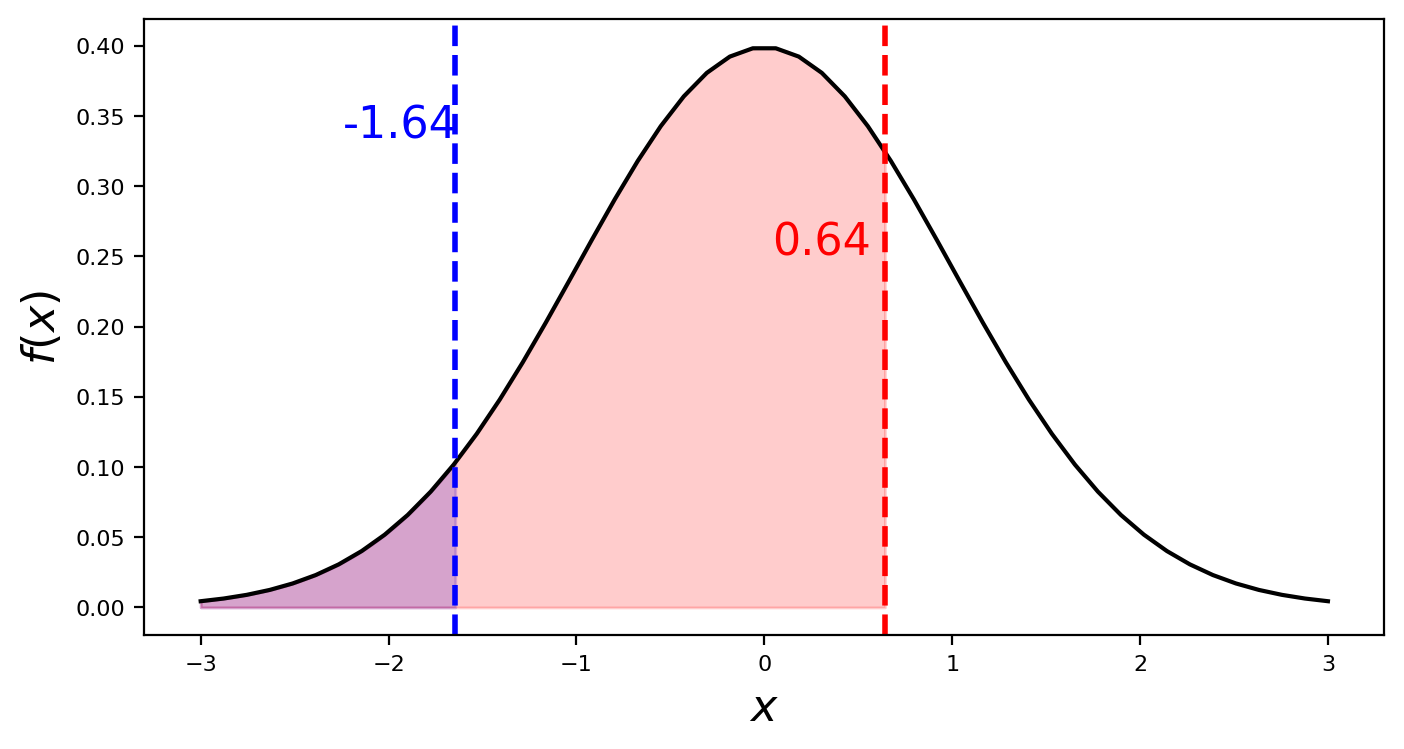

In [23]:
asy_mean_test(diff, diff_std, alpha=0.05, alternative='less')

Видим, что мы не можем отвергнуть нашу нулевую гипотезу, то есть популярность цвета не сильно влияет на цену. Можем посмотреть на распределения, чтобы убедится в том, что примененные тест имеет место быть.

<Figure size 1500x600 with 0 Axes>

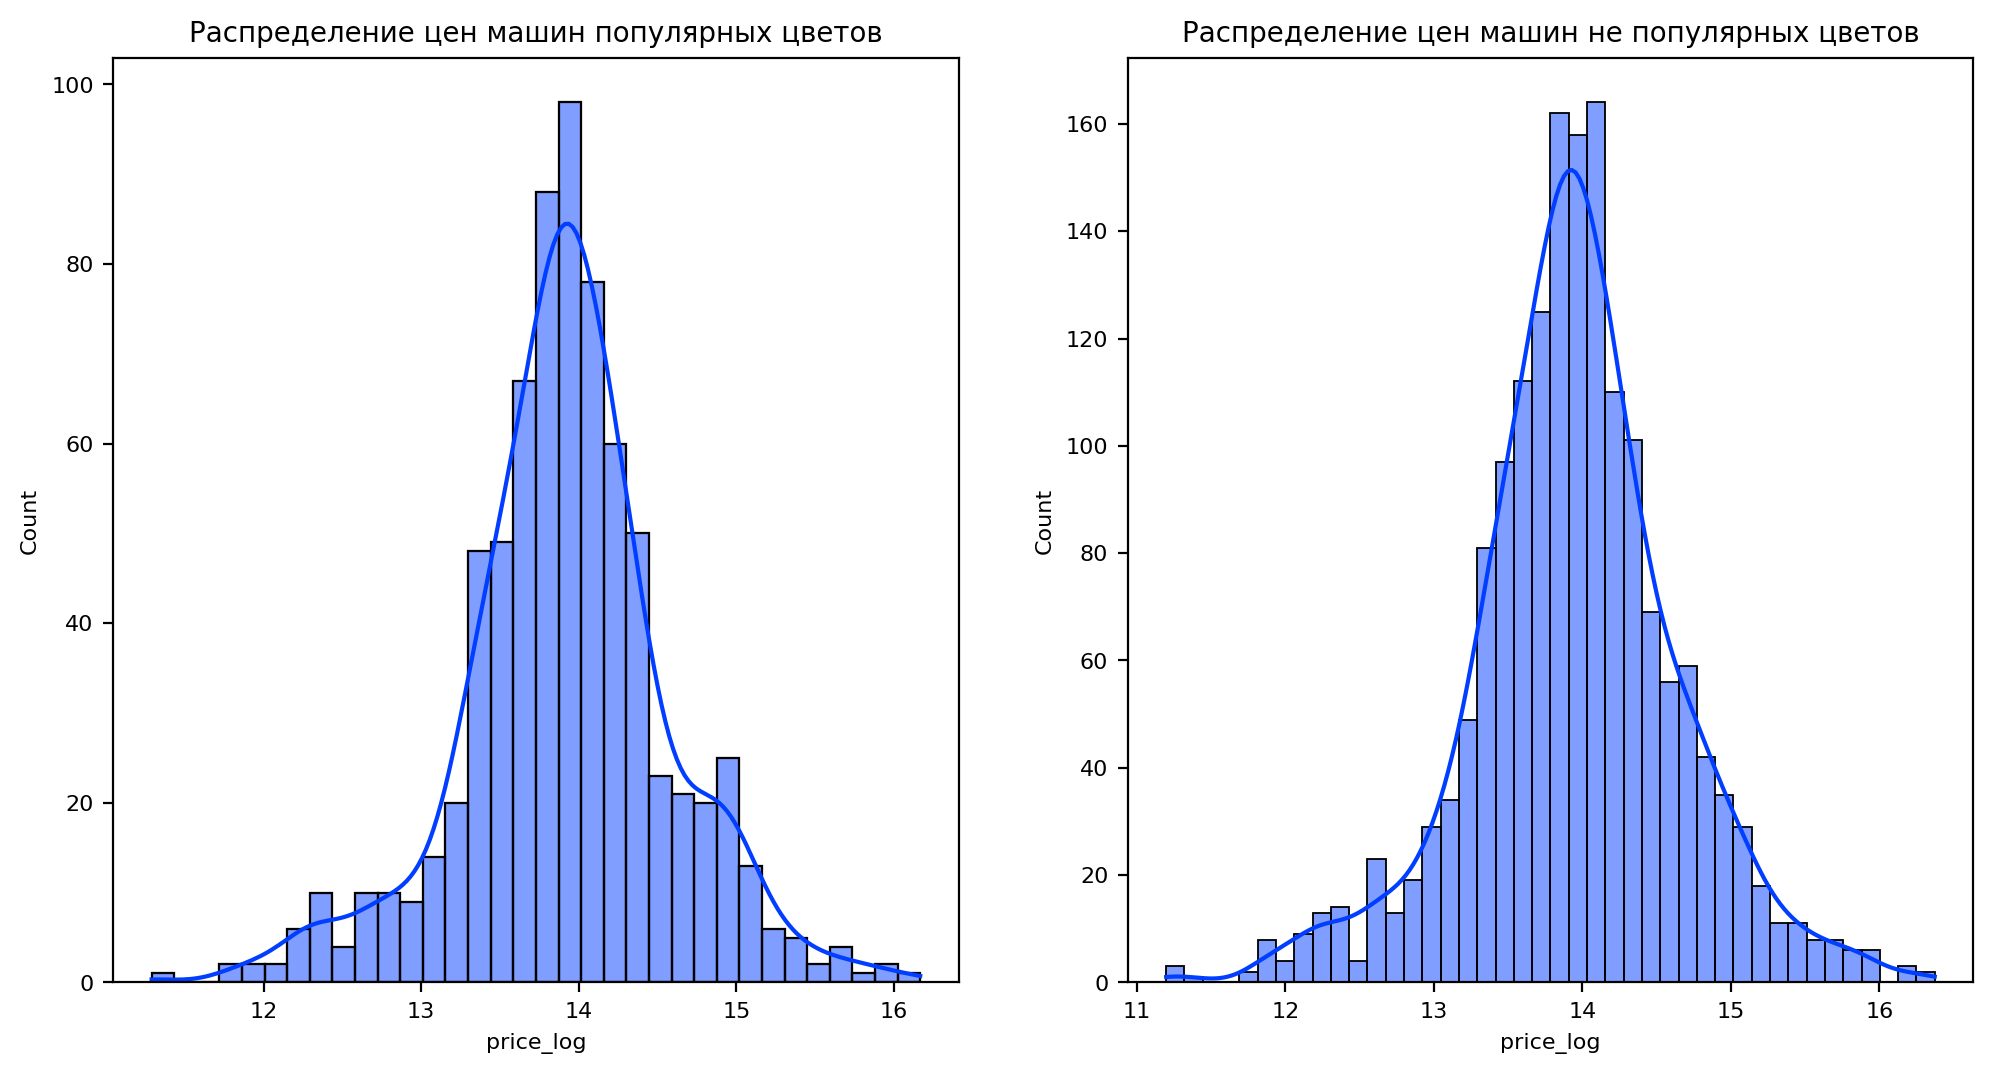

In [24]:
plt.figure(figsize=(15, 6))
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

sns.histplot(x, kde=True, ax=axes[0]) 
axes[0].set_title('Распределение цен машин популярных цветов')

sns.histplot(y, kde=True, ax=axes[1]) 
axes[1].set_title('Распределение цен машин не популярных цветов')

plt.show()

Видим, что распределения очень похожи на нормальные, а число выбросов мало => тест достоверный.

## Правда ли, что возможность обмена, число предыдущих продаж, и тех. история практически никак не влияют на цену?

Чтобы подготовится к машинному обучению, давайте проведем тест отношения правдоподобия и посмотрим, отличаются ли модели с (полная модель) и без (вложенная модель) указанных переменных. Гипотезы будут следующими:

$H_0:$ Полная модель и вложенная модель одинаково хорошо соответствуют данным (то есть можем использовать только вложенную модель)


$H_1:$  Полная модель соответствует данным значительно лучше, чем вложенная модель (т.е. нужно использовать полную модель)

Уровень значимости возьмем 5%

In [25]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

df.columns

Index(['title', 'year', 'age', 'run', 'owners_pts', 'modification', 'volume',
       'engine_type', 'transmission', 'gear', 'body', 'color', 'exchange',
       'mark', 'other_history', 'tech_history', 'sold', 'subway', 'pts_type',
       'price', 'horse_power', 'price_log', 'one_owner', 'subway_avg_mins',
       'car_brand'],
      dtype='object')

В данном примере будем использовать только числовые переменные и закодированную переменную возможности обмена (тк она принимает только 3 значения)

In [26]:
num_cols = df.select_dtypes(include='number').columns
num_cols

Index(['year', 'run', 'volume', 'engine_type', 'other_history', 'tech_history',
       'sold', 'price', 'horse_power', 'price_log', 'one_owner',
       'subway_avg_mins'],
      dtype='object')

In [27]:
cols = ['year', 'run', 'volume', 'engine_type', 'other_history', 'tech_history',
       'sold', 'horse_power', 'one_owner', 'subway_avg_mins', 'exchange']

In [28]:
x1 = pd.get_dummies(df[cols], columns=['exchange'], drop_first=False, dtype=int)
y = df['price_log']

In [29]:
x1 = sm.add_constant(x1)


full_model = sm.OLS(y, x1).fit()

full_ll = full_model.llf
full_ll

-550.6575515187774

In [30]:
cols_less = ['year', 'run', 'volume', 'engine_type', 'other_history', 'horse_power', 'one_owner', 'subway_avg_mins']
x2 = df[cols_less]

x2 = sm.add_constant(x2)

reduced_model = sm.OLS(y, x2).fit()

reduced_ll = reduced_model.llf

reduced_ll

-576.7837856057786

рассчитаем хи-квадрат и p_value логарифмического правдоподобия

In [31]:
import scipy
LR_statistic = -2 * (reduced_ll-full_ll)

print(LR_statistic)

p_val = scipy.stats.chi2.sf(LR_statistic, 2)

p_val, p_val < alpha

52.25246817400239


(4.503194477997951e-12, True)

Так как p_value < alpha, то нулевая гипотеза отвергается, а значит надо будет использовать полную модель в анализе

# Finally... ML

Задача: Предсказание цены машины по ее описанию и характеристикам

Зачем? Хотим понимать, какие параметры влияют на цену машины, чтобы можно было
а) понимать цену при продаже
б) при покупке машины понимать возможную цену по характеристикам

Как будем реализовывать? Так как у нас достаточно большое число признаков, а корреляция между признаками и ценой небольшая, то скорее всего линейная модель не сможет хорошо переобучится. Попробуем построить рэндом форест и посмотреть, есть ли какие-то сложные зависимости в наших данных. В качестве признаков будем использовать следующие колонки:
['year',  'run', 'volume', 'engine_type', 'transmission', 'gear', 'body', 'color', 'exchange', 'mark',  'tech_history', 'sold', 'pts_type', 'horse_power', 'price_log', 'one_owner', 'subway_avg_mins', 'car_brand']


*NB почему именно эти колонки: в процессе предыдущего анализа выяснились основные переменные, которые могут незначительно, но влиять на цену*

In [32]:
X = df[['year', 'run', 'volume', 'engine_type', 'transmission', 'gear', 'body', 'color', 'exchange', 'mark', 'other_history', 'tech_history', 'sold', 'pts_type', 'horse_power', 
        'one_owner', 'subway_avg_mins', 'car_brand']]
y = df['price_log']


In [33]:
X.head()

,year,run,volume,engine_type,transmission,gear,body,color,exchange,mark,other_history,tech_history,sold,pts_type,horse_power,one_owner,subway_avg_mins,car_brand
0,2019,91037,3.3,0,Автомат,Полный,Седан,Чёрный,Возможен,соответствует,2,4,1,Другое,249,0,15.50,Kia
1,2017,95250,2.1,1,Автомат,Полный,Minivan,Чёрный,Не интересует,соответствует,2,19,2,Оригинал,190,0,16.17,Mercedes-Benz
2,2013,113000,1.4,0,Автомат,Передний,Хэтчбек,Красный,Возможен,ниже,2,5,3,Другое,140,0,21.33,Opel
3,2015,165000,2.0,1,Автомат,Полный,Внедорожник,Белый,Возможен,ниже,2,5,1,Другое,140,0,26.67,Volkswagen
4,2018,103000,1.5,0,Автомат,Полный,Внедорожник,Белый,другое,соответствует,1,10,1,Оригинал,150,1,20.50,Ford


In [34]:
# выберем категориальные признаки чтобы перевести их OneHotEncoding

cat_cols = X.select_dtypes(include='object').columns

X = pd.get_dummies(X, columns=cat_cols, drop_first=True, dtype=int)

In [35]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [36]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

В качестве метрики будем использовать mse, так как она хорошо подойдет для логарифмированных данных

In [37]:
from sklearn.metrics import mean_squared_error as mse

y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

print(f"Test MSE = {round(mse(y_test, y_pred), 3)}")
print(f"Train MSE = {round(mse(y_train, y_train_pred), 3)}")

Test MSE = 0.076
Train MSE = 0.011


Видим что результат получился почти идеальным. Посмотрим на важность признаков:

In [38]:
importances = rf.feature_importances_
names = rf.feature_names_in_

df_imp = pd.DataFrame({'feture_names':names,  'importances': importances})
df_imp['importances'] = df_imp['importances'].apply(lambda x: round(x, 4))

In [39]:
df_imp.sort_values(by=['importances'], ascending=False)[:10]

,feture_names,importances
7,horse_power,0.4221
0,year,0.3531
1,run,0.0439
2,volume,0.0259
35,mark_ниже,0.0185
9,subway_avg_mins,0.0144
3,engine_type,0.0143
5,tech_history,0.0084
13,gear_Передний,0.0068
6,sold,0.0066


In [40]:
df_imp.sort_values(by=['importances'], ascending=False)[-10:]

,feture_names,importances
62,car_brand_Isuzu,0.0
63,car_brand_Iveco,0.0
64,car_brand_JAC,0.0
65,car_brand_JAECOO,0.0
80,car_brand_OMODA,0.0
66,car_brand_Jaguar,0.0
67,car_brand_Jeep,0.0
68,car_brand_Jetour,0.0
70,car_brand_LIFAN,0.0
87,car_brand_Skywell,0.0


Можем сделать вывод, что марка машины никак не влияет на цену, а вот число лошадиных сил, год выпуска, пробег, объем бака влияют. Более того, можем обратить внимание на то. что оценка ниже оценки авито является важной для цены, как и передний привод. Попробуем оставить только топ 10 переменных и посмотреть на новую модель

In [41]:
df_imp.sort_values(by=['importances'], ascending=False)[:10]['feture_names']

7         horse_power
0                year
1                 run
2              volume
35          mark_ниже
9     subway_avg_mins
3         engine_type
5        tech_history
13      gear_Передний
6                sold
Name: feture_names, dtype: object

In [42]:
cols = df_imp.sort_values(by=['importances'], ascending=False)[:10]['feture_names']
rf2 = RandomForestRegressor()
rf2.fit(X_train[cols], y_train)

y_pred = rf2.predict(X_test[cols])
y_train_pred = rf2.predict(X_train[cols])

print(f"Test MSE = {round(mse(y_test, y_pred), 3)}")
print(f"Train MSE = {round(mse(y_train, y_train_pred), 3)}")

Test MSE = 0.085
Train MSE = 0.012


Видим, что модель переобучилась. Значит все же переменные, которые мы убрали, в совокупности имели небольшой вес, но значительное влияние на результат обучения.

# ну вот и все...

Long story short или основные выводы из всей работы:

Ключевыми параметрами, которые влияют на цену автомобиля являются год выпуска, пробег, число лошадиных сил и объем двигателя, что в  целом вполне ожидаемо и заметно при выборе машины. Казалось бы цвет, число предыдущих владельцев или тип багажника могли бы влиять на цену – но нет, данные переменные слабо коррелируют с ценой, как и марка машины.
В целом это может свидетельствовать о большом разнообразии рынка машин: по интересующим человека зарактеристикам, можно найти машины по разным ценам, которые вполне будут его устраивать (и даже найти станцию метро, возле которой встретиться с владельцем будет комфортнее всего)

*Совет от автора: при покупке машины лучше обратить внимание не на новые, а уже машины с небольшим пробегом, так как они будут чуть дешевле, а их качество – ничем не хуже. Также марка машины – не всегда означает ее качество или высокую цену, как и число владельцев не всегда говорит о том, что машина плохая*.